In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Import libraries
import os
from dotenv import load_dotenv 
import redshift_connector
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway

from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, SplineTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline

from sklearn.metrics import r2_score
import joblib

## **Connect to Redshift Cluster**

In [3]:
# Load environment variables from .env file
load_dotenv()

True

In [4]:
# Retrieve values from environment variables
host = os.getenv("REDSHIFT_HOST")
database = os.getenv("REDSHIFT_DATABASE")
user = os.getenv("REDSHIFT_USER")
password = os.getenv("REDSHIFT_PASSWORD")
port = os.getenv("REDSHIFT_PORT")

In [5]:
# Connect to the cluster
try:
    conn = redshift_connector.connect(
        host=host,
        database=database,
        user=user,
        password=password,
        port=port
    )
    print("Connection to AWS Redshift successful!")
except Exception as e:
    print("Error connecting to AWS Redshift:", e)

Connection to AWS Redshift successful!


## **Fetch entire data**

In [6]:
query = "select * from public.data"
data = pd.read_sql(query, conn)

In [7]:
data.head()

,item_identifier,item_weight,item_fat_content,item_visibility,item_type,item_mrp,outlet_identifier,outlet_establishment_year,outlet_size,outlet_location_type,outlet_type,item_outlet_sales
0,DRC01,5.920,Regular,0.019278,Soft Drinks,48.269199,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
1,FDN15,17.500,Low Fat,0.016760,Meat,141.617996,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
2,NCD19,8.930,Low Fat,0.000000,Household,53.861401,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
3,FDP36,10.395,Regular,0.000000,Baking Goods,51.400799,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
4,FDO10,13.650,Regular,0.012741,Snack Foods,57.658798,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528


In [8]:
# Save the data
data.to_csv("../data/data.csv")

## **Data Preprocessing**

In [9]:
# Find out rows where `item_weight` is missing -> already checked using this query in AWS Redshift
query = "SELECT * FROM public.data WHERE item_weight IS NULL;"
data = pd.read_sql(query, conn)
data.head()

,item_identifier,item_weight,item_fat_content,item_visibility,item_type,item_mrp,outlet_identifier,outlet_establishment_year,outlet_size,outlet_location_type,outlet_type,item_outlet_sales
0,FDN52,None,Regular,0.130933,Frozen Foods,86.919800,OUT027,1985,Medium,Tier 3,Supermarket Type3,1569.9564
1,FDK57,None,Low Fat,0.079904,Snack Foods,120.043999,OUT027,1985,Medium,Tier 3,Supermarket Type3,4434.2280
2,FDE52,None,Regular,0.029742,Dairy,88.951401,OUT027,1985,Medium,Tier 3,Supermarket Type3,3453.5046
3,FDQ60,None,Regular,0.191501,Baking Goods,121.209801,OUT019,1985,Small,Tier 1,Grocery Store,120.5098


In [10]:
# Filling missing records with respect to values from other columns -> already updated using this query in AWS Redshift
'''
cursor = conn.cursor()

sql_string_update = """UPDATE public.data
                       SET item_weight = b.maxweight
                       FROM public.data a
                       INNER JOIN
                            (
                                SELECT item_identifier, MAX(item_weight) AS maxweight
                                FROM public.data
                                GROUP BY item_identifier
                            ) b
                       ON a.item_identifier = b.item_identifier
                       WHERE a.item_weight IS NULL;"""

sql_ = sql_string_update.format("Null")

cursor.execute(sql_string_update)

conn.commit()
'''

'\ncursor = conn.cursor()\n\nsql_string_update = """UPDATE public.data\n                       SET item_weight = b.maxweight\n                       FROM public.data a\n                       INNER JOIN\n                            (\n                                SELECT item_identifier, MAX(item_weight) AS maxweight\n                                FROM public.data\n                                GROUP BY item_identifier\n                            ) b\n                       ON a.item_identifier = b.item_identifier\n                       WHERE a.item_weight IS NULL;"""\n\nsql_ = sql_string_update.format("Null")\n\ncursor.execute(sql_string_update)\n\nconn.commit()\n'

#### Fill missing values of `outlet_size` column by "Small"

In [11]:
cursor = conn.cursor()
# Define the SQL query with placeholders
sql_string_update = """UPDATE public.data SET outlet_size = %s WHERE outlet_size = %s;"""
# Define the values to use in the query
params = ('Small', '')
# Execute the query with parameters
cursor.execute(sql_string_update, params)
# Commit the changes
conn.commit()

In [12]:
# Load the data again
query = "SELECT * FROM public.data;"
data = pd.read_sql(query, conn)
data.head()

,item_identifier,item_weight,item_fat_content,item_visibility,item_type,item_mrp,outlet_identifier,outlet_establishment_year,outlet_size,outlet_location_type,outlet_type,item_outlet_sales
0,DRC01,5.920,Regular,0.019278,Soft Drinks,48.269199,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
1,FDN15,17.500,Low Fat,0.016760,Meat,141.617996,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
2,NCD19,8.930,Low Fat,0.000000,Household,53.861401,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
3,FDP36,10.395,Regular,0.000000,Baking Goods,51.400799,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
4,FDO10,13.650,Regular,0.012741,Snack Foods,57.658798,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528


In [13]:
# Close the connection
conn.close()

In [14]:
# After imputation, let's check the unique values present in `outlet_size` column. Expectation: No '' values
data["outlet_size"].unique()

array(['Medium', 'High', 'Small'], dtype=object)

## **Exploratory Data Analysis**

In [15]:
# Display a concise summary of the DataFrame, including the index dtype, column data types, non-null values, and memory usage
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8522 entries, 0 to 8521
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   item_identifier            8522 non-null   object 
 1   item_weight                8518 non-null   float64
 2   item_fat_content           8522 non-null   object 
 3   item_visibility            8522 non-null   float64
 4   item_type                  8522 non-null   object 
 5   item_mrp                   8522 non-null   float64
 6   outlet_identifier          8522 non-null   object 
 7   outlet_establishment_year  8522 non-null   int64  
 8   outlet_size                8522 non-null   object 
 9   outlet_location_type       8522 non-null   object 
 10  outlet_type                8522 non-null   object 
 11  item_outlet_sales          8522 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


**Observation:**

There are 8523 records present in all the columns, except in `item_weight` column. We have already seen it after fetching the data from AWS Redshift database. We can remove these 4 records.

In [16]:
# Filter rows where 'item_weight' column is not NaN (i.e., keep only rows with non-null values in 'item_weight')
df = data[data['item_weight'].notna()]

In [17]:
# Display a concise summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8518 entries, 0 to 8521
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   item_identifier            8518 non-null   object 
 1   item_weight                8518 non-null   float64
 2   item_fat_content           8518 non-null   object 
 3   item_visibility            8518 non-null   float64
 4   item_type                  8518 non-null   object 
 5   item_mrp                   8518 non-null   float64
 6   outlet_identifier          8518 non-null   object 
 7   outlet_establishment_year  8518 non-null   int64  
 8   outlet_size                8518 non-null   object 
 9   outlet_location_type       8518 non-null   object 
 10  outlet_type                8518 non-null   object 
 11  item_outlet_sales          8518 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 865.1+ KB


### 1. Categorical Variable Analysis

* **item_fat_content:**

In [18]:
# Count the occurrences of each unique value in the 'item_fat_content' column
df["item_fat_content"].value_counts()

item_fat_content
Low Fat    5087
Regular    2886
LF          316
reg         117
low fat     112
Name: count, dtype: int64

**Observation:**
The `item_fat_content` column has inconsistent labels for similar categories (e.g., "Low Fat" and "low fat" or "LF"; "Regular" and "reg"). This suggests variations in how fat content is labeled, which could lead to incorrect analysis or insights.

**Next Actions:**

1. Standardize Labels: Replace variations with consistent labels (e.g., convert all "low fat" and "LF" to "Low Fat" and "reg" to "Regular") to ensure accurate grouping and analysis.
2. Recheck Value Counts: After standardizing, re-run value_counts() to confirm that categories are consolidated correctly.

In [19]:
# Define the replacement dictionary
replacement_dict = {
    'item_fat_content': {
        'low fat': 'Low Fat',
        'LF': 'Low Fat',
        'reg': 'Regular'
    }
}

In [20]:
# Replace the values in the DataFrame 
df.replace(replacement_dict, inplace=True)

In [21]:
# Verify the changes
print(df['item_fat_content'].value_counts())

item_fat_content
Low Fat    5515
Regular    3003
Name: count, dtype: int64


* **item_type:**

In [22]:
# Count the occurrences of each unique value in the 'item_type' column
df["item_type"].value_counts()

item_type
Fruits and Vegetables    1232
Snack Foods              1199
Household                 910
Frozen Foods              855
Dairy                     680
Canned                    649
Baking Goods              647
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64

* **outlet_size:**

<Axes: xlabel='outlet_size', ylabel='count'>

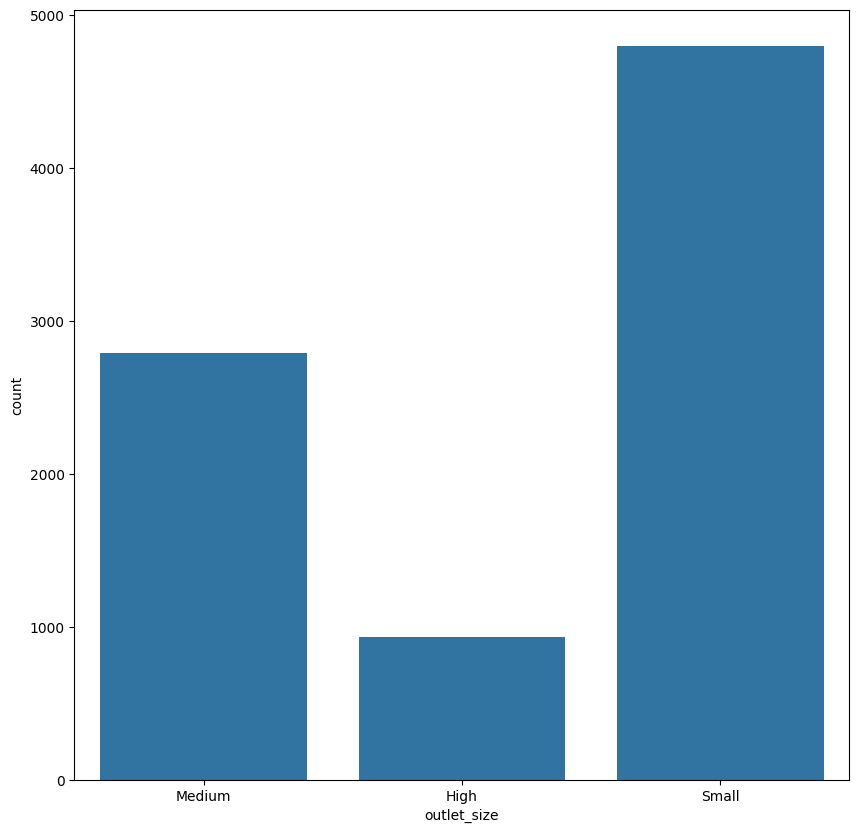

In [23]:
# Set the figure size and create a count plot to visualize the distribution of values in the 'outlet_size' column
plt.figure(figsize=(10,10))
sns.countplot(x='outlet_size',data=df)

**Observation:** 

`Small` Outlet size stores are much more in number.

* **outlet_type:**

<Axes: xlabel='outlet_type', ylabel='count'>

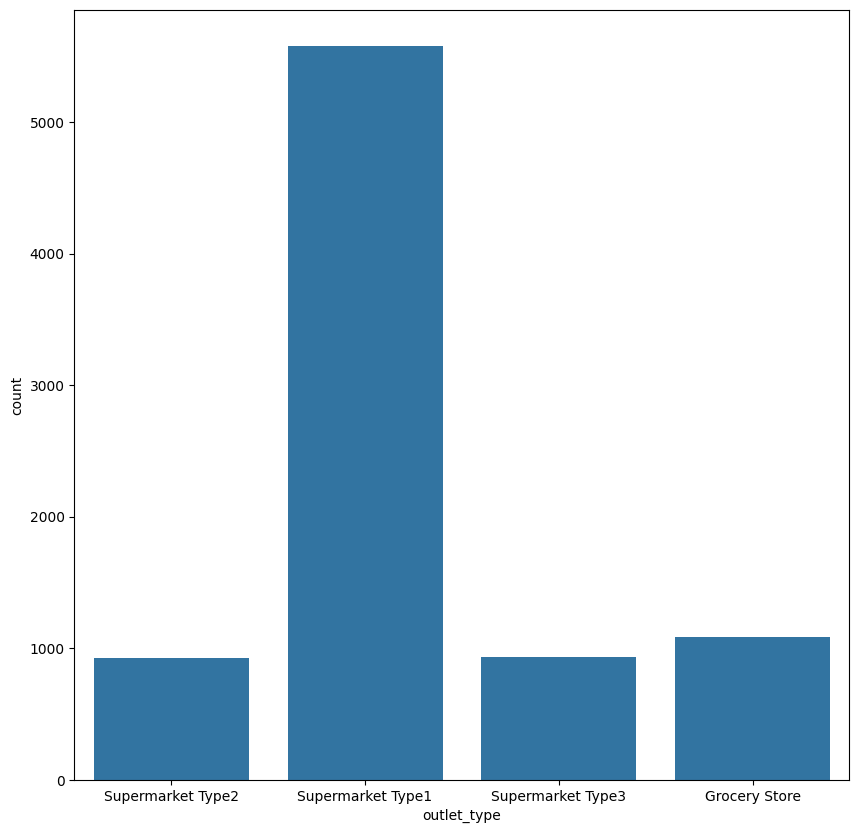

In [24]:
# Set the figure size and create a count plot to visualize the distribution of values in the 'outlet_type' column
plt.figure(figsize=(10,10))
sns.countplot(x='outlet_type',data=df)

**Observation:** 

`Supermarket Type1` is the most frequent outlet type in the data.

* **outlet_establishment_year:**

<Axes: xlabel='outlet_establishment_year', ylabel='count'>

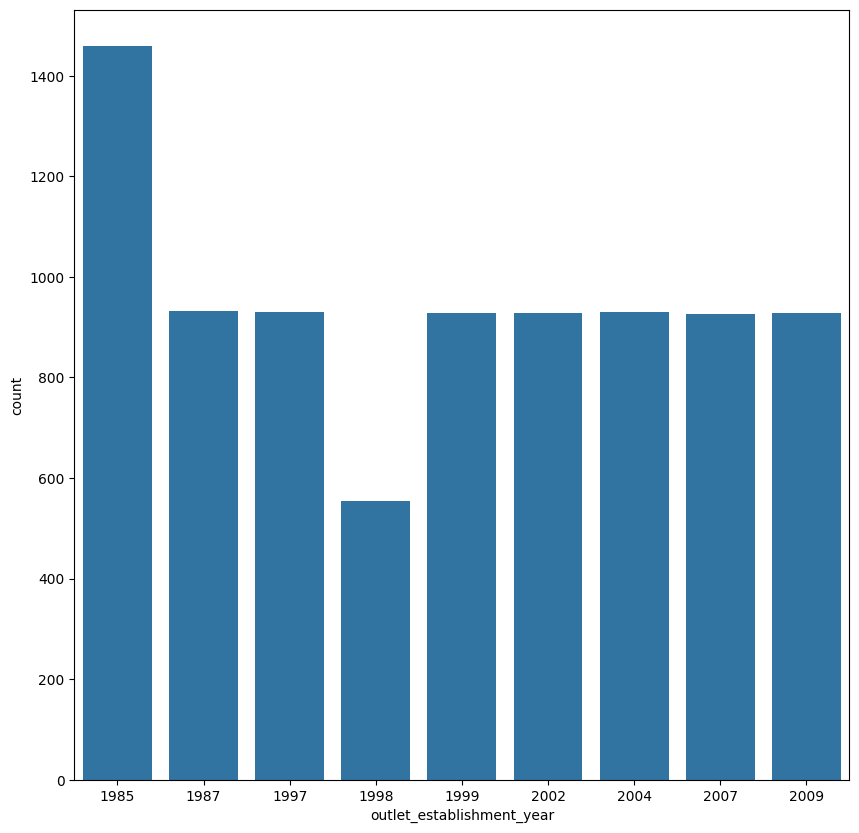

In [25]:
# Set the figure size and create a count plot to visualize the distribution of values in the 'outlet_establishment_year' column
plt.figure(figsize=(10,10))
sns.countplot(x='outlet_establishment_year',data=df)

**Observation:** 

Most stores were opened in the year 1985 and least in 1998.

### 2. Continuous variable analysis

* **item_weight:**

<Axes: xlabel='item_weight', ylabel='Density'>

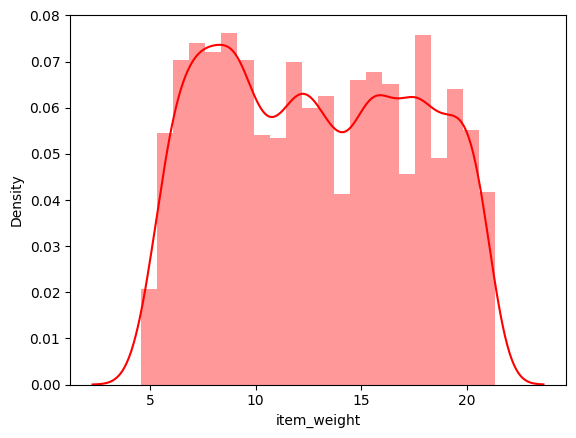

In [26]:
# Plot the distribution of 'item_weight' to observe its original spread and detect skewness or uniformity
sns.distplot(df['item_weight'],color='red')

**Observation:**

The distribution plot of item_weight shows a roughly uniform distribution with multiple small peaks and a relatively flat structure, indicating that the item weights are spread fairly evenly across the range, with no strong central tendency. This might suggest that no single weight range dominates, and there is a variety of item weights.

<Axes: xlabel='item_weight', ylabel='Density'>

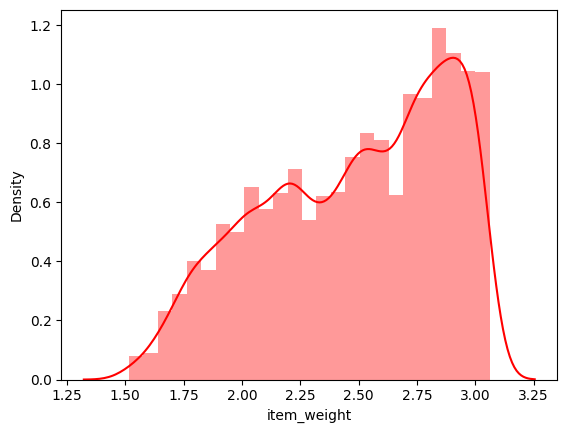

In [27]:
# Plot the distribution of the logarithmic transformation of 'item_weight' to normalize skewness, using a red color
sns.distplot(np.log(df['item_weight']),color='red')

**Observation:**

The logarithmic transformation of item_weight shows a positively skewed distribution, with a primary peak near 2.75. This suggests that the majority of item weights, after log transformation, cluster around this value. The log transformation has reduced the skewness to some extent, making the distribution more symmetrical than it would be in the original scale, which can improve the performance of models sensitive to normally distributed features.

**Next Probable Action:**

Consider `standardizing` or `normalizing` the `item_weight` data if required by modeling approach, as this can further enhance model performance by ensuring consistent scale across features.

* **item_visibility:**

<Axes: xlabel='item_visibility', ylabel='Density'>

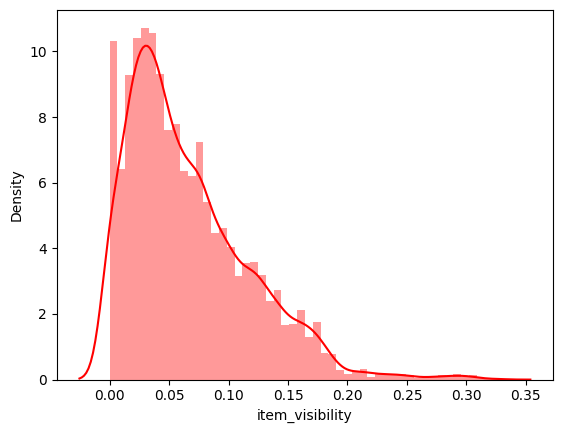

In [28]:
# Plot the distribution of 'item_visibility' to assess its spread and skewness
sns.distplot(df['item_visibility'],color='red')

**Observation:**

The `item_visibility` distribution is highly skewed to the right, with most values concentrated near zero and a long tail extending towards higher values. This suggests that a majority of items have low visibility, with a few items having significantly higher visibility.

**Next Probable Action:**

Consider applying a `logarithmic` or other `power transformation` to reduce skewness and normalize the distribution. This can improve the feature's suitability for machine learning models that assume a normal distribution.

* **item_mrp:**

<Axes: xlabel='item_mrp', ylabel='Density'>

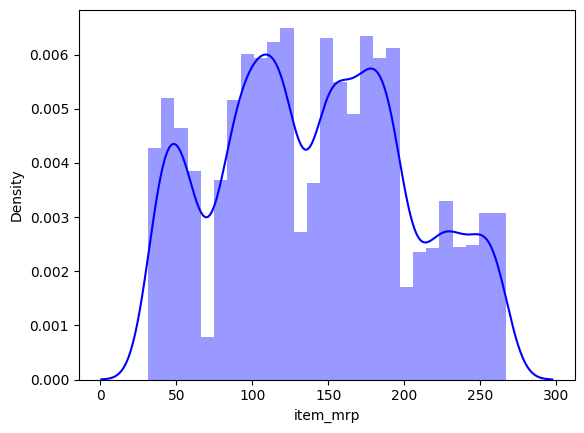

In [29]:
# Plot the distribution of 'item_mrp' to observe pricing clusters and distribution characteristics
sns.distplot(df['item_mrp'],color='blue')

**Observation:**

The distribution of item_mrp (Maximum Retail Price) appears multimodal, with multiple peaks across different price ranges, indicating varied pricing clusters within the data. This suggests that the items are priced in distinct groups rather than having a continuous, uniform distribution.

<Axes: xlabel='item_mrp', ylabel='Density'>

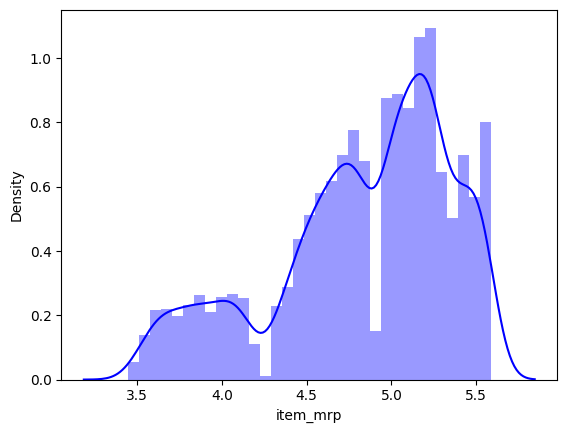

In [30]:
#MRP
sns.distplot(np.log(df['item_mrp']),color='blue')

**Observation:**

The log-transformed item_mrp distribution shows a bimodal pattern, with two prominent peaks around 4.5 and 5.0. This suggests that, even after transformation, item_mrp has natural clusters in certain price ranges, though the transformation has helped reduce any extreme skewness.

**Next Probable Action:**

Investigate the reason behind these distinct price clusters, as they might represent different product categories or pricing strategies. You could consider using these clusters as a feature for analysis or modeling, or further explore segmentation to see if it impacts other variables.

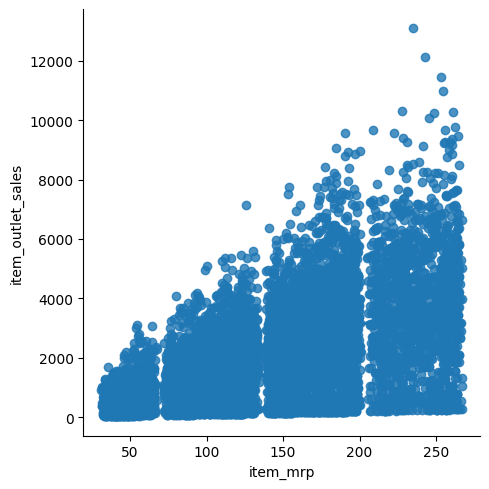

In [31]:
# Plot the relationship between 'item_mrp' and 'item_outlet_sales' to observe correlation and sales trends with respect to price
sns.lmplot(data=df, x="item_mrp",y="item_outlet_sales")

**Observation:**

The scatter plot shows a `positive correlation` between `item_mrp` and `item_outlet_sales`. As the item_mrp increases, the item_outlet_sales also tends to increase, indicating that higher-priced items generally generate more sales in terms of revenue.

**Next Probable Action:**

Consider calculating the correlation coefficient between item_mrp and item_outlet_sales to quantify the strength of this relationship. Additionally, you could segment item_mrp into bins to analyze if the sales trend remains consistent across different price ranges or if there are notable variations.

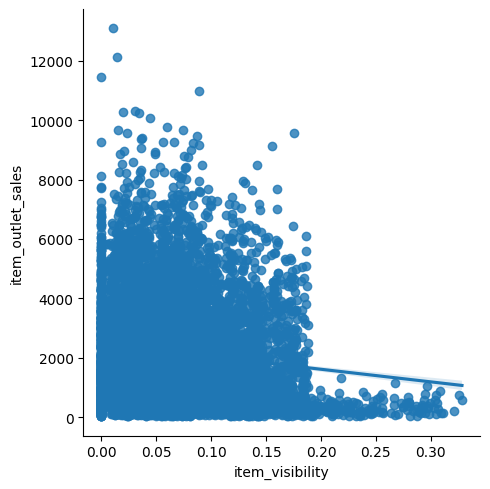

In [32]:
# Plot the relationship between 'item_visibility' and 'item_outlet_sales' to examine the impact of visibility on sales
sns.lmplot(data=df,x="item_visibility",y="item_outlet_sales")

**Observation:**

The scatter plot indicates a slight negative correlation between `item_visibility` and `item_outlet_sales`. Higher item visibility does not appear to contribute significantly to sales, and sales tend to decrease marginally as visibility increases. Most data points are concentrated at lower visibility values, with a wide range of sales.

**Next Action:**

Consider exploring other factors that may influence item_outlet_sales, as item_visibility alone does not appear to have a strong effect. You may also want to check for multicollinearity with other features or create interaction terms to see if visibility impacts sales in combination with other variables.

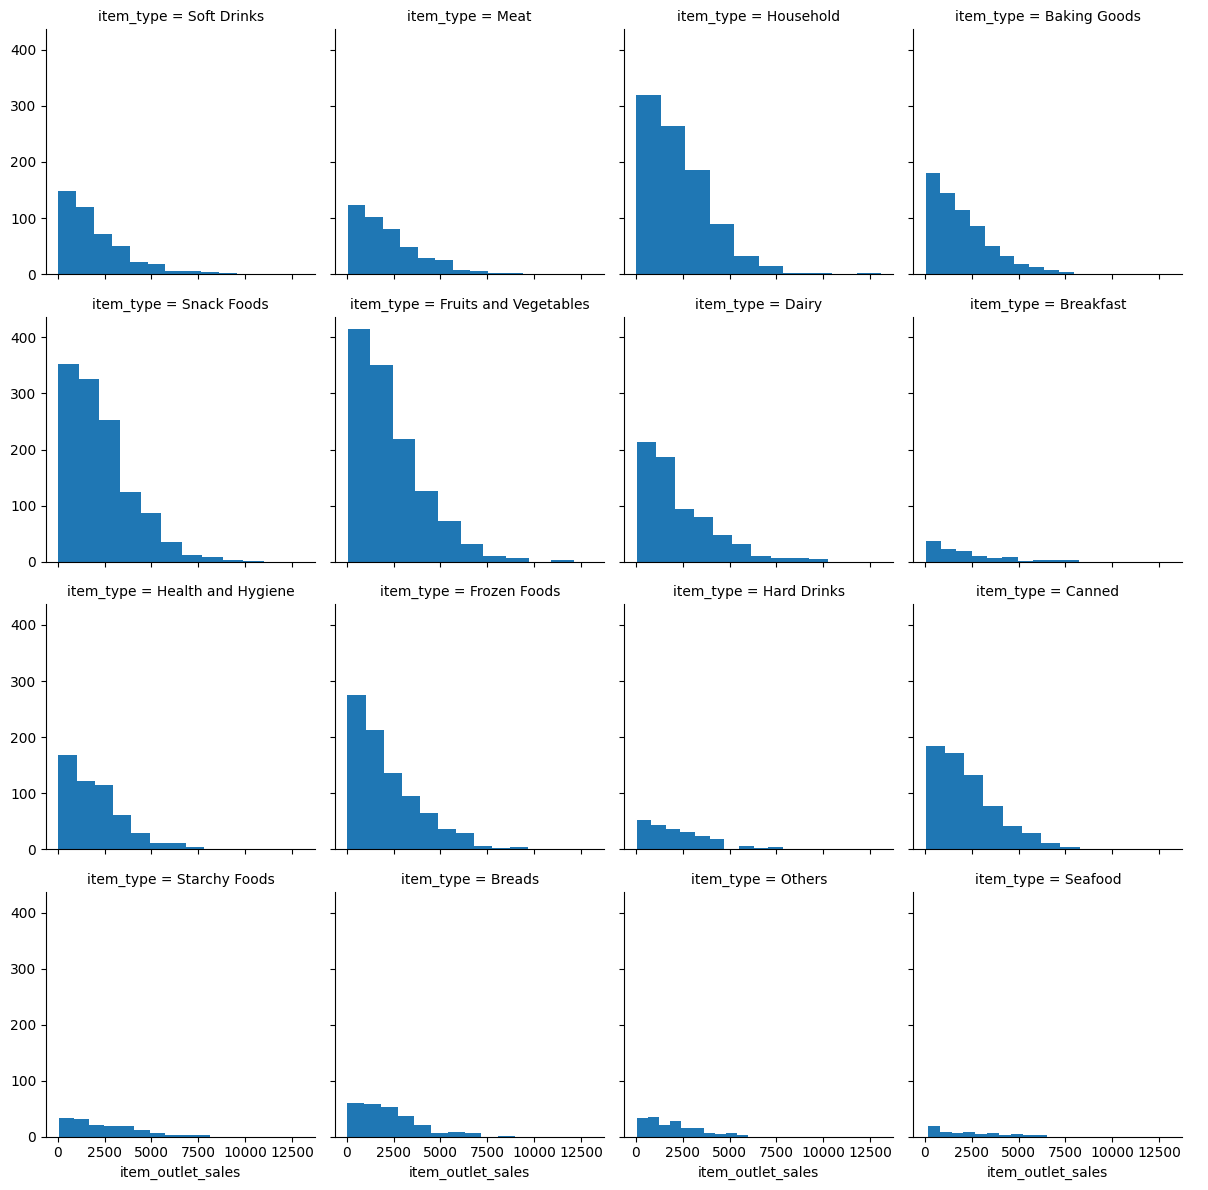

In [33]:
# Plot the distribution of 'item_outlet_sales' across different 'item_type' categories to identify sales patterns for each item type
sns.FacetGrid(df, col='item_type',col_wrap=4).map(plt.hist,'item_outlet_sales').add_legend()

**Observation:**

The histograms show the distribution of `item_outlet_sales` across different `item_type` categories. Most categories display a right-skewed distribution, with the majority of sales concentrated at lower values. Certain categories, like "Household", "Fruits and Vegetables", "Snack Foods", "Dairy" and "Frozen Foods", have relatively higher sales counts, indicating they are likely popular or high-selling items compared to others.

### Correlation

In [34]:
# Select only the numeric columns from the DataFrame
numeric_df = df.select_dtypes(include=['float64', 'int64'])

In [35]:
# Calculate the correlation matrix for numeric columns
corr = numeric_df.corr()

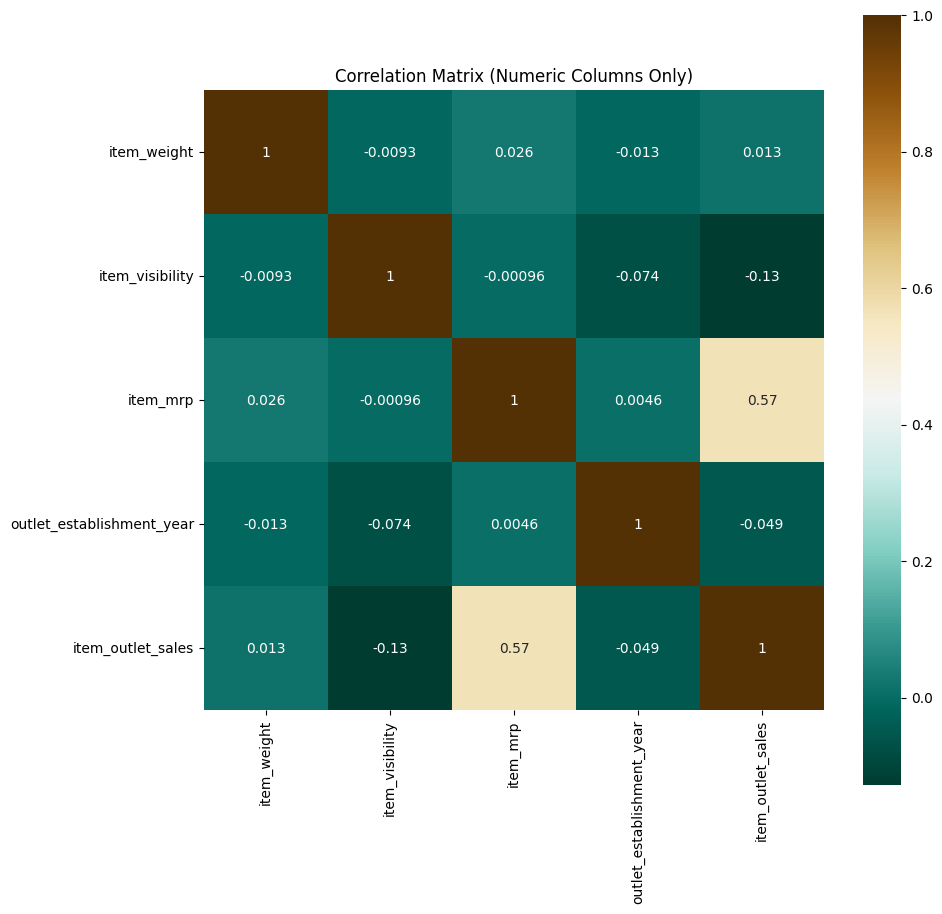

In [36]:
# Plot the correlation heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(corr, cbar=True, square=True, annot=True, cmap='BrBG_r')
plt.title("Correlation Matrix (Numeric Columns Only)")
plt.show()

**Observation:**

The correlation heatmap shows that `item_mrp` has a moderate positive correlation (0.57) with `item_outlet_sales`, indicating that items with higher prices tend to have higher sales. Other variables, such as `item_weight`, `item_visibility`, and `outlet_establishment_year`, have very weak correlations with `item_outlet_sales` and each other, suggesting they do not significantly impact sales directly.

This analysis indicates that `item_mrp` may be an important predictor for `item_outlet_sales`, while the other numeric features are likely less influential.

## **Categorical Correlation**

### Chi Squared Test

* **outlet_size and outlet_type**

In [37]:
# Create a cross-tabulation of 'outlet_size' and 'outlet_type' to examine their relationship
cross_tab = pd.crosstab(index=df["outlet_size"], columns=df["outlet_type"])
cross_tab

outlet_type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
outlet_size,,,,
High,0,932,0,0
Medium,0,929,928,932
Small,1082,3715,0,0


In [38]:
# Perform the Chi-square test of independence to determine if there is a significant relationship between 'outlet_size' and 'outlet_type'
result = chi2_contingency(cross_tab)
result

Chi2ContingencyResult(statistic=np.float64(5375.495873539656), pvalue=np.float64(0.0), dof=6, expected_freq=array([[ 118.38741489,  610.10002348,  101.53745011,  101.97511153],
       [ 354.2730688 , 1825.71777413,  303.84972998,  305.1594271 ],
       [ 609.33951632, 3140.18220239,  522.61281991,  524.86546138]]))

#### H0 (Null Hypothesis) : There is no significance between `outlet_size` and `outlet_type`

In [39]:
print("The p value is: ",result[1])

The p value is:  0.0


**Observation:**

The Chi-square test result for the 3x4 contingency table between outlet_size and outlet_type shows a significant association (p-value of 0.0). However, while the Chi-square test is generally applicable to tables larger than 2x2, this particular result may not be reliable due to low expected frequencies in some cells.

Reasons to be cautious with the Chi-Square Test in this case:

**1. Low Expected Frequencies:** Some cells in the table have expected frequencies below the recommended threshold of 5 (e.g., the expected frequency for "Grocery Store" and "High" is around 118.38). Low expected counts can lead to an inflated Chi-square statistic, making the test result overly significant.

**2. Table Size:** In larger tables (like 3x4), even slight deviations from expected values can lead to high Chi-square statistics, which may not accurately represent the strength of association but only the size of the table.

**3. Significance vs. Strength of Association:** The Chi-square test tells us whether an association exists, but it does not indicate the strength of this association. In business contexts, knowing the strength of the relationship is often more relevant to understanding the practical impact.


**Next Action:**

Use `Cramér's V` instead to measure the strength of the relationship, providing a clearer, size-adjusted interpretation of the association.

### Cramér's V Test

In [40]:
# Create function to perform Cramér's V Test
def cramers_v(x, y):
    """
    Calculate Cramér's V statistic for measuring the strength of association between two categorical variables.

        Parameters:
            x (pd.Series): The first categorical variable.
            y (pd.Series): The second categorical variable.

        Returns:
            float: Cramér's V statistic, ranging from 0 to 1, where 0 indicates no association and 1 indicates a strong association.
    """
    # Create a contingency table for the two categorical variables
    contingency_table = pd.crosstab(x, y, rownames=None, colnames=None)

    # Perform Chi-square test on the contingency table and get the Chi-square statistic
    chi2_stat = chi2_contingency(contingency_table)[0]

    # Calculate the total number of observations
    n = contingency_table.sum().sum()

    # Calculate the minimum dimension (rows or columns) minus 1
    min_dim = min(contingency_table.shape)-1

    # Calculate and return Cramér's V
    return np.sqrt(chi2_stat/(n * min_dim))

In [41]:
# Encode categorical variables using Label Encoding
label_encoder = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame()

In [42]:
# Apply label encoding to each specified column and store in a new DataFrame
for column in df[["outlet_type", "outlet_size", "outlet_location_type"]].columns:
    data_encoded[column] = label_encoder.fit_transform(data[column])

In [43]:
# Initialize a list to store Cramér's V values for each variable pair
cramers_v_matrix = []

In [44]:
# Calculate Cramér's V for each pair of encoded categorical variables
for col1 in data_encoded.columns:
    row = []  # Temporary list to hold Cramér's V values for col1 against all other columns
    for col2 in data_encoded.columns:
        # Compute Cramér's V for the pair (col1, col2) and round the result
        cramers_value = cramers_v(data_encoded[col1], data_encoded[col2])
        row.append(round(cramers_value, 2))
    # Append the row list to the main matrix
    cramers_v_matrix.append(row)

In [45]:
# Convert the Cramér's V matrix to a DataFrame for easier interpretation
cramers_v_results = pd.DataFrame(cramers_v_matrix, columns=data_encoded.columns, index=data_encoded.columns)
cramers_v_results

,outlet_type,outlet_size,outlet_location_type
outlet_type,1.00,0.56,0.53
outlet_size,0.56,1.00,0.53
outlet_location_type,0.53,0.53,1.00


**Observation:**

The Cramér's V matrix shows moderate associations between `outlet_type` and both `outlet_size` (0.56) and `outlet_location_type` (0.53), indicating that these variables are not independent and have a noticeable relationship. This suggests that the type of outlet is somewhat related to its size and location type, which may reflect strategic decisions in outlet planning.

## Correlation between One Numeric and One Categorical Variable

### One-Way ANOVA Test

H0 (Null Hypothesis): There is no correlation between variables

p value < 0.05 -> Reject my null hypothesis

* **outlet_location_type** and **item_outlet_sales**

In [46]:
# Prepare data for ANOVA by grouping 'item_outlet_sales' by 'outlet_size' and storing each group's values in a DataFrame
anova_data = df.groupby("outlet_size")["item_outlet_sales"].apply(list).reset_index(name="item_outlet_sales")

In [47]:
# Display the resulting DataFrame with each outlet_size and its associated list of sales
anova_data

,outlet_size,item_outlet_sales
0,High,"[994.7052, 343.5528, 1977.426, 3775.086, 308.9..."
1,Medium,"[443.4228, 2097.27, 556.6088, 1516.0266, 1589...."
2,Small,"[2187.153, 2145.2076, 1547.3192, 2748.4224, 15..."


In [48]:
# Extract only the lists of sales values for each `outlet_size` group to pass into the f_oneway function
sales_values = anova_data["item_outlet_sales"]

In [49]:
# Perform the One-Way ANOVA test
# The * operator unpacks the list so that each list of sales values for an outlet_size is passed as a separate argument
anova_results = f_oneway(*sales_values)
anova_results

F_onewayResult(statistic=np.float64(212.80711849699244), pvalue=np.float64(6.525835900937984e-91))

In [50]:
print("The p value is",anova_results[1])

The p value is 6.525835900937984e-91


**Observation:**

The One-Way ANOVA test yields a very small p-value (6.52e-91), which is far below any typical significance level (e.g., 0.05). This indicates a statistically significant difference in `item_outlet_sales` means across different `outlet_size` groups. In other words, the outlet size has a significant impact on sales, suggesting that different outlet sizes may drive different levels of sales performance. The Null Hypothesis has been rejected & there is a very high correlation between `outlet_size` & `item_outlet_sales`.

* **outlet_type** and **item_outlet_sales**

In [51]:
# Prepare data for ANOVA by grouping 'item_outlet_sales' by 'outlet_type' and storing each group's values in a DataFrame
anova_data = df.groupby("outlet_type")["item_outlet_sales"].apply(list).reset_index(name="item_outlet_sales")

In [52]:
# Extract only the lists of sales values for each `outlet_type` group to pass into the f_oneway function
sales_values = anova_data["item_outlet_sales"]

In [53]:
# Perform the One-Way ANOVA test
# The * operator unpacks the list so that each list of sales values for an outlet_type is passed as a separate argument
anova_results = f_oneway(*sales_values)
anova_results

F_onewayResult(statistic=np.float64(893.4802946838308), pvalue=np.float64(0.0))

In [54]:
print("The p value is",anova_results[1])

The p value is 0.0


**Observation:**

The One-Way ANOVA test yields p-value = 0.0, which is below any typical significance level (e.g., 0.05). The outlet type has a significant impact on sales, suggesting that different outlet types may drive different levels of sales performance. The Null Hypothesis has been rejected & there is a very high correlation between `outlet_type` & `item_outlet_sales`.

* **outlet_location_type** and **item_outlet_sales**

In [55]:
# Prepare data for ANOVA by grouping 'item_outlet_sales' by 'outlet_location_type' and storing each group's values in a DataFrame
anova_data = df.groupby("outlet_location_type")["item_outlet_sales"].apply(list).reset_index(name="item_outlet_sales")

In [56]:
# Extract only the lists of sales values for each `outlet_type` group to pass into the f_oneway function
sales_values = anova_data["item_outlet_sales"]

In [57]:
# Perform the One-Way ANOVA test
# The * operator unpacks the list so that each list of sales values for an outlet_location_type is passed as a separate argument
anova_results = f_oneway(*sales_values)
anova_results

F_onewayResult(statistic=np.float64(53.82907280706569), pvalue=np.float64(5.873308176020326e-24))

In [58]:
print("The p value is",anova_results[1])

The p value is 5.873308176020326e-24


**Observation:**

The One-Way ANOVA test yields a very small p-value (5.87e-24), which is far below any typical significance level (e.g., 0.05). This indicates a statistically significant difference in `item_outlet_sales` means across different `outlet_location_type` groups. In other words, the outlet size has a significant impact on sales, suggesting that different outlet sizes may drive different levels of sales performance. The Null Hypothesis has been rejected & there is a very high correlation between `outlet_location_type` & `item_outlet_sales`.

## **Feature Engineering**

In [59]:
df.head()

,item_identifier,item_weight,item_fat_content,item_visibility,item_type,item_mrp,outlet_identifier,outlet_establishment_year,outlet_size,outlet_location_type,outlet_type,item_outlet_sales
0,DRC01,5.920,Regular,0.019278,Soft Drinks,48.269199,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
1,FDN15,17.500,Low Fat,0.016760,Meat,141.617996,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
2,NCD19,8.930,Low Fat,0.000000,Household,53.861401,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
3,FDP36,10.395,Regular,0.000000,Baking Goods,51.400799,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
4,FDO10,13.650,Regular,0.012741,Snack Foods,57.658798,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528


In [60]:
df["outlet_age"] = 2024 - df["outlet_establishment_year"]
df = df.drop(columns=["outlet_establishment_year"])

df.head()

,item_identifier,item_weight,item_fat_content,item_visibility,item_type,item_mrp,outlet_identifier,outlet_size,outlet_location_type,outlet_type,item_outlet_sales,outlet_age
0,DRC01,5.920,Regular,0.019278,Soft Drinks,48.269199,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,15
1,FDN15,17.500,Low Fat,0.016760,Meat,141.617996,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,25
2,NCD19,8.930,Low Fat,0.000000,Household,53.861401,OUT013,High,Tier 3,Supermarket Type1,994.7052,37
3,FDP36,10.395,Regular,0.000000,Baking Goods,51.400799,OUT018,Medium,Tier 3,Supermarket Type2,556.6088,15
4,FDO10,13.650,Regular,0.012741,Snack Foods,57.658798,OUT013,High,Tier 3,Supermarket Type1,343.5528,37


In [61]:
# Categorical variable Encoding
# Initialize the LabelEncoder for encoding categorical variables
le = LabelEncoder()

# List of columns with categorical data to be label-encoded
col_encode = ["item_fat_content", "outlet_identifier", "outlet_size", "outlet_location_type", "outlet_type"]

# Loop through each column in the list and apply label encoding
for col in col_encode:
    df[col] = le.fit_transform(df[col])

# Create a new DataFrame by dropping the 'item_identifier' column, as it may not be relevant for analysis
df_new = df.drop(columns=["item_identifier"], axis=1)

# Convert remaining categorical columns to dummy variables (one-hot encoding) for model compatibility
df_new = pd.get_dummies(df_new)

# Display the first few rows of the transformed DataFrame to verify encoding
df_new.head()

,item_weight,item_fat_content,item_visibility,item_mrp,outlet_identifier,outlet_size,outlet_location_type,outlet_type,item_outlet_sales,outlet_age,...,item_type_Fruits and Vegetables,item_type_Hard Drinks,item_type_Health and Hygiene,item_type_Household,item_type_Meat,item_type_Others,item_type_Seafood,item_type_Snack Foods,item_type_Soft Drinks,item_type_Starchy Foods
0,5.920,1,0.019278,48.269199,3,1,2,2,443.4228,15,...,False,False,False,False,False,False,False,False,True,False
1,17.500,0,0.016760,141.617996,9,1,0,1,2097.2700,25,...,False,False,False,False,True,False,False,False,False,False
2,8.930,0,0.000000,53.861401,1,0,2,1,994.7052,37,...,False,False,False,True,False,False,False,False,False,False
3,10.395,1,0.000000,51.400799,3,1,2,2,556.6088,15,...,False,False,False,False,False,False,False,False,False,False
4,13.650,1,0.012741,57.658798,1,0,2,1,343.5528,37,...,False,False,False,False,False,False,False,True,False,False


## **Split the data**

In [62]:
# Define the feature set 'X' by dropping the target variable 'item_outlet_sales' from the DataFrame
X = df_new.drop(columns=["item_outlet_sales"], axis=1)
# Define the target variable 'y' as the 'item_outlet_sales' column
y = df_new["item_outlet_sales"]

# Split the data into training and testing sets
# Set aside 20% of the data for testing, with a random seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Modeling**

In [63]:
# List of models to evaluate, each represented as a tuple with a name and an instantiated model object
models = [
    ("lr", LinearRegression()),             # Linear Regression model
    ("ElasticNet", ElasticNet()),           # ElasticNet model (combination of L1 and L2 regularization)
    ("RF", RandomForestRegressor()),        # Random Forest Regressor model
    ("ETR", ExtraTreesRegressor()),         # Extra Trees Regressor model
    ("GBM", GradientBoostingRegressor()),   # Gradient Boosting Regressor model
    ("MLP", MLPRegressor())                 # Multi-layer Perceptron Regressor (neural network)
]

In [64]:
# Define a function to perform cross-validation on multiple models and print the average scores
def model_selection_func(X, y, cross_folds, models):
    """
    Evaluates multiple regression models using cross-validation and prints the mean cross-validation score for each.

    Parameters:
        X (pd.DataFrame): The feature matrix.
        y (pd.Series): The target vector.
        cross_folds (int): The number of cross-validation folds.
        models (list): List of tuples containing model names and instantiated model objects.

    Returns:
        None
    """
    # Initialize lists to store model names and their cross-validation scores
    scores = []
    names = []
    
    # Perform cross-validation for each model in the list
    for model_name, model_instance in models:
        # Cross-validate the model and append the mean score to scores list
        cv_scores = cross_val_score(model_instance, X, y, cv=cross_folds, n_jobs=-1)
        scores.append(cv_scores)
        names.append(model_name)
    
    # Print the mean cross-validation score for each model
    for idx in range(len(scores)):
        print(f"{names[idx]}: Mean CV Score = {scores[idx].mean():.4f}")

    return

In [65]:
# Call the model_selection_func function to evaluate multiple models using cross-validation
model_selection_func(X_train, y_train, 5, models)

lr: Mean CV Score = 0.4964
ElasticNet: Mean CV Score = 0.4719
RF: Mean CV Score = 0.5525
ETR: Mean CV Score = 0.5010
GBM: Mean CV Score = 0.5903
MLP: Mean CV Score = 0.4966


/Users/abhinandansamal/anaconda3/envs/myenv2/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/abhinandansamal/anaconda3/envs/myenv2/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/abhinandansamal/anaconda3/envs/myenv2/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/abhinandansamal/anaconda3/envs/myenv2/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the 

**Observation:**

The output shows that the Gradient Boosting Regressor (GBM) has the highest mean cross-validation score (0.59), indicating it performs best among the models tested. The Random Forest Regressor (RF) also performs relatively well with a mean score of 0.55. Conversely, Linear Regression (lr) and ElasticNet models have lower mean scores, suggesting they may not capture the complexity of the data as effectively as the ensemble methods.

The MLPRegressor displays a ConvergenceWarning, meaning it reached the maximum number of iterations (200) without fully converging. This could indicate that the model requires more iterations or better parameter tuning to achieve optimal performance.

**Next Probable Action:**

1. Parameter Tuning: For the MLPRegressor, consider increasing the number of iterations or adjusting hyperparameters (e.g., learning rate, hidden layer sizes) to achieve convergence.

2. Hyperparameter Tuning: Given that Gradient Boosting and Random Forest performed well, try hyperparameter tuning (e.g., grid search or random search) on these models to potentially improve their performance further.

3. Model Selection: Based on initial scores, Gradient Boosting is a strong candidate for further development or deployment.

In [66]:
# Creates a pipeline that applies a Spline transformation followed by a linear regression model
spline_model = make_pipeline(SplineTransformer(n_knots=3, degree=5), LinearRegression())

# Performs 5-fold cross-validation on the spline_model using the training data (X_train, y_train)
# `cv=5` specifies 5-fold, and `n_jobs=-1` enables parallel processing to speed up computation
scores = cross_val_score(spline_model, X_train, y_train, cv=5, n_jobs=-1)

# Calculates the average of the cross-validation scores to estimate the model's performance
scores.mean()

np.float64(0.5567624931402997)

## **Model Ensembling**

### Voting Regressor

In [67]:
# Create average of model predictions

# Initialize a Linear Regression model
reg1 = LinearRegression()
# Initialize a Gradient Boosting Regressor
reg2 = GradientBoostingRegressor()
# Initialize a Multi-Layer Perceptron Regressor
reg3 = MLPRegressor()

# Combines the three models into a Voting Regressor, which will make predictions by averaging the outputs of each model
# The models are labeled as "LR" for Linear Regression, "GBM" for Gradient Boosting, and "MLP" for Multi-Layer Perceptron
voting_regress = VotingRegressor(estimators=[("LR", reg1), ("GBM", reg2), ("MLP", reg3)])

# Performs 3-fold cross-validation on the Voting Regressor model using the training data
# `cv=3` specifies 3-fold cross-validation
scores = cross_val_score(voting_regress, X_train, y_train, cv=3)

In [68]:
# Print the individual cross-validation scores for each fold
print(scores)

# Print the average cross-validation score, providing an overall performance metric for the model
print(scores.mean())

[0.56439086 0.53943561 0.5538259 ]
0.5525507907037154


**Observation:**

The average cross-validation score of 0.55 indicates that the Voting Regressor has moderate predictive accuracy on the training data. The scores across the folds are fairly consistent, suggesting stable performance, though there may be room for improvement in model accuracy with tuning or alternative models.

### Stacking / Stacked Generalization

In [69]:
# Initialize a Linear Regression model to be used as a base model in the stack
linear_regressor = LinearRegression()
# Initialize a Gradient Boosting Regressor to capture non-linear relationships as a base model in the stack
gradient_boosting_regressor = GradientBoostingRegressor()
# Combine base models into a list of estimators, naming each model for clarity in the Stacking Regressor
base_estimators = [("LR", linear_regressor), ("GBM", gradient_boosting_regressor)]
# Set up a Ridge Regression model as the final (meta) estimator in the stacking model
meta_estimator = Ridge()
# Combine the base models and meta estimator into a Stacking Regressor model
stacking_regressor = StackingRegressor(estimators=base_estimators, final_estimator=meta_estimator)

# Perform 3-fold cross-validation on the stacking model with the training data
# The cv=3 specifies 3-fold cross-validation to evaluate the stacking regressor's performance
scores = cross_val_score(stacking_regressor, X_train, y_train, cv=3)

# Print the cross-validation scores for each fold, showing the model’s performance
print(scores)

[0.6065163  0.58915366 0.58891577]


**Observation:**

The cross-validation scores of [0.6065163  0.58915366 0.58891577] indicate a relatively consistent performance across the three folds, with a small variation among them. The average score, approximately 0.5948, suggests that the stacking regressor model has reasonably good predictive accuracy on the training data.

The use of both a linear and a gradient boosting model as base estimators, combined with a linear regression as the meta-estimator, is likely contributing to this stability. However, there may still be room for improvement by experimenting with different hyperparameters or by adding more diverse base models to further capture complex patterns and improve overall accuracy.

### Blending

In [70]:
# Split X_train and y_train into new training and validation sets with a 90-10 split for model validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [71]:
def list_models():
    """
    Creates and returns a list of basic regression models for training.
    
    Returns:
        list: A list of tuples where each tuple contains a model name (str) 
              and an instance of a regression model.
    """
    models = []
    models.append(('LR', LinearRegression()))  # Add a Linear Regression model with the identifier 'LR'
    models.append(('GBR', GradientBoostingRegressor()))  # Add a Gradient Boosting Regressor with the identifier 'GBR'
    
    return models  # Returns the list of models

In [72]:
def fit_all_models(models, X_train, X_val, y_train, y_val):
    """
    Trains each base model on the training data, predicts on validation data, and 
    trains a meta-model using the predictions from each base model as features.
    
    Parameters:
        models (list): A list of tuples containing model names and model instances.
        X_train (array-like): Training data for the base models.
        X_val (array-like): Validation data for generating predictions.
        y_train (array-like): Target values for the training data.
        y_val (array-like): Target values for the validation data.
        
    Returns:
        MLPRegressor: The meta-model trained on the stacked predictions of base models.
    """
    # Store predictions from each base model to be used as features for meta-model
    level_1_features = []

    for name, model in models:
        # Train each base model on the training data
        model.fit(X_train, y_train)
        # Predict on the validation set
        y_pred = model.predict(X_val)
        # Reshape predictions for stacking
        y_pred = y_pred.reshape(len(y_pred), 1)
        # Appends predictions to the level_1_features list
        level_1_features.append(y_pred)

    # Horizontally stack all predictions as meta-model features
    level_1_features = np.hstack(level_1_features)

    # Initialize the meta-model, in this case, a Multi-Layer Perceptron Regressor
    meta_model = MLPRegressor()
    # Train the meta-model on the stacked features and validation targets
    meta_model.fit(level_1_features, y_val)

    return meta_model

In [73]:
def pred_data(models, meta_model, X_test):
    """
    Predicts on test data using base models and the meta-model for final predictions.
    
    Parameters:
        models (list): A list of tuples containing model names and model instances.
        meta_model (MLPRegressor): The trained meta-model to predict on stacked features.
        X_test (array-like): Test data for generating predictions.
        
    Returns:
        array: Final predictions made by the meta-model.
    """
    # Store predictions from each base model as input for the meta-model
    meta_model_features = []

    for name, model in models:
        # Predict on the test data using each base model
        y_pred = model.predict(X_test)
        # Reshape predictions for stacking
        y_pred = y_pred.reshape(len(y_pred), 1)
        # Append reshaped predictions to the list
        meta_model_features.append(y_pred)

    # Horizontally stacks all test predictions as meta-model input
    meta_model_features = np.hstack(meta_model_features)
    
    # Returns the meta-model's final predictions on test data
    return meta_model.predict(meta_model_features)

In [74]:
# Initialize the list of models
models = list_models()

# Train the stacking model, using the base models to create features for the meta-model
meta_model_trained = fit_all_models(models, X_train_split, X_val_split, y_train_split, y_val_split)

# Generate predictions on the original training data using the trained meta-model
y_predictions = pred_data(models, meta_model_trained, X_train)

In [75]:
y_predictions

array([2421.43122616, 2586.47675042, 1812.52484586, ...,  592.42142843,
       3356.11310804,  281.3946172 ])

## Model Evaluation

In [76]:
r2_score(y_train, y_predictions)

0.6312200760708326

In [77]:
scores = cross_val_score(meta_model_trained, X_train, y_train, cv=3)
scores

array([0.48103211, 0.47671437, 0.48891683])

In [78]:
print(scores.mean())

0.4822211047848615


**Observation:**

The average score, approximately 0.48, suggests that the blending regressor model has worse predictive accuracy on the training data than stacking regressor model.

In [79]:
# Predict the target values for the test set using the blending model (meta-model trained with predictions from base models)
y_pred_blend = pred_data(models, meta_model_trained, X_test)
print("R2 of Blending is:")
# Calculate and display the R2 score for the blending model
print(r2_score(y_test, y_pred_blend))

# Train the stacking model on the full training data and generate predictions on the test data
stacking_trained = stacking_regressor.fit(X_train, y_train)
y_pred_stack = stacking_trained.predict(X_test)
print("R2 of Stacking is:")
# Calculate and displays the R2 score for the stacking model
print(r2_score(y_test, y_pred_stack))

# Initialize and train a standalone Gradient Boosting Regressor, then generate predictions on the test data
gbm_model = GradientBoostingRegressor()
# Fit the GBM model on the full training data
gbm_model.fit(X_train, y_train)
y_pred_gbm = gbm_model.predict(X_test)
print("R2 of GBM is:")
# Calculates and displays the R2 score for the GBM model
print(r2_score(y_test, y_pred_gbm))

R2 of Blending is:
0.6017943988443193
R2 of Stacking is:
0.6015128207600244
R2 of GBM is:
0.6006092611709313


**Observation:**

Based on the outputs, the ```Blending model``` and the ```Stacking model``` show slightly better performance compared to the standalone Gradient Boosting model:
* Blending Model: Cross-validation mean R2 score is 0.4822, but the test R2 score is 0.6017, which suggests it performs well in generalization on unseen data.
* Stacking Model: Cross-validation mean R2 score is 0.5948, with a test R2 score of 0.6015, indicating consistently strong performance in both cross-validation and test evaluation.
* Gradient Boosting Model: Test R2 score of 0.6006, which is slightly lower than both the blending and stacking models.

**Next Action:**
For hyperparameter tuning, the Blending model and Stacking model should be prioritized, as they exhibit slightly higher R2 scores on the test set compared to the standalone Gradient Boosting model. Focusing on these two models is likely to yield the best improvement in performance on unseen data.

## Hyperparameter Tuning

#### 1. Hyperparameter Tuning for Stacking Model

In [80]:
# Define an expanded parameter grid for the stacking model (only tuning fit_intercept as before)
stacking_param_grid = {
    'final_estimator__alpha': [0.1, 1.0, 10.0],  # Regularization strength for Ridge regression
    'final_estimator__fit_intercept': [True, False]  # Whether to calculate the intercept for this model
}

In [81]:
# Set up GridSearchCV for the stacking model with 5-fold cross-validation for more stable evaluation
stacking_grid_search = GridSearchCV(
    estimator=stacking_regressor,
    param_grid=stacking_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

In [82]:
# Fit the grid search on training data for the stacking model
stacking_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=StackingRegressor(estimators=[('LR', LinearRegression()),
                                                     ('GBM',
                                                      GradientBoostingRegressor())],
                                         final_estimator=Ridge()),
             n_jobs=-1,
             param_grid={'final_estimator__alpha': [0.1, 1.0, 10.0],
                         'final_estimator__fit_intercept': [True, False]},
             scoring='r2')

In [83]:
# Retrieve and evaluate the best stacking model
best_stacking_model = stacking_grid_search.best_estimator_

In [84]:
# Predict on test data using the best stacking model and calculate R2 score
y_pred_best_stack = best_stacking_model.predict(X_test)
print("Best R2 for Stacking Model (after tuning):")
print(r2_score(y_test, y_pred_best_stack))

Best R2 for Stacking Model (after tuning):
0.6016203633058869


#### 2. Hyperparameter Tuning for Blending Model

In [85]:
# Define parameter grids for the base models and the meta-model

# Parameter grid for Linear Regression
lr_param_grid = {
    'fit_intercept': [True, False]
}

# Parameter grid for Gradient Boosting Regressor
gbr_param_grid = {
    'n_estimators': [100, 200],         # Number of boosting stages
    'learning_rate': [0.05, 0.1, 0.2],  # Learning rate shrinks contribution of each tree
    'max_depth': [3, 4, 5]              # Maximum depth of the trees
}

# Parameter grid for the meta-model (MLPRegressor)
meta_param_grid = {
    'hidden_layer_sizes': [(50,), (100,)],  # Number of neurons in the hidden layer(s)
    'activation': ['relu', 'tanh'],         # Activation functions for hidden layers
    'alpha': [0.0001, 0.001],               # Regularization parameter
    'learning_rate': ['constant', 'adaptive']
}

In [86]:
# Initialize the base models with individual GridSearchCV for each
# GridSearch for Linear Regression (base model)
lr_search = GridSearchCV(
    estimator=LinearRegression(),
    param_grid=lr_param_grid,
    scoring='r2',
    cv=3,
    n_jobs=-1
)

In [87]:
# Fit GridSearch on Linear Regression using training data
lr_search.fit(X_train_split, y_train_split)

GridSearchCV(cv=3, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False]}, scoring='r2')

In [88]:
# Retrieve the best linear regression model from the grid search
best_lr_model = lr_search.best_estimator_

In [89]:
# GridSearch for Gradient Boosting Regressor (base model)
gbr_search = GridSearchCV(
    estimator=GradientBoostingRegressor(),
    param_grid=gbr_param_grid,
    scoring='r2',
    cv=3,
    n_jobs=-1
)

In [90]:
# Fit GridSearch on Gradient Boosting Regressor using training data
gbr_search.fit(X_train_split, y_train_split)
best_gbr_model = gbr_search.best_estimator_

In [91]:
# List of tuned base models for blending
tuned_models = [
    ('LR', best_lr_model),
    ('GBR', best_gbr_model)
]

In [92]:
# Re-train the meta-model with tuned base models' predictions
def fit_all_models_tuned(models, X_train, X_val, y_train, y_val):
    """
    Trains each tuned base model on the training data, predicts on validation data, and 
    trains a meta-model using the predictions from each base model as features.
    
    Parameters:
        models (list): A list of tuples containing model names and tuned model instances.
        X_train (array-like): Training data for the base models.
        X_val (array-like): Validation data for generating predictions.
        y_train (array-like): Target values for the training data.
        y_val (array-like): Target values for the validation data.
        
    Returns:
        MLPRegressor: The meta-model trained on the stacked predictions of base models.
    """
    # Store predictions from each base model to be used as features for the meta-model
    level_1_features = []

    for name, model in models:
        # Train each base model on the training data
        model.fit(X_train, y_train)
        # Predict on the validation set
        y_pred = model.predict(X_val)
        # Reshape predictions for stacking
        y_pred = y_pred.reshape(len(y_pred), 1)
        # Append predictions to the level_1_features list
        level_1_features.append(y_pred)

    # Horizontally stack all predictions as meta-model features
    level_1_features = np.hstack(level_1_features)

    # GridSearch for meta-model (MLPRegressor)
    meta_model_search = GridSearchCV(
        estimator=MLPRegressor(),
        param_grid=meta_param_grid,
        scoring='r2',
        cv=3,
        n_jobs=-1
    )

    # Fit GridSearch on the meta-model using level 1 features and validation targets
    meta_model_search.fit(level_1_features, y_val)
    best_meta_model = meta_model_search.best_estimator_

    return best_meta_model

In [93]:
# Train the blending model with tuned base models and meta-model
meta_model_trained = fit_all_models_tuned(tuned_models, X_train_split, X_val_split, y_train_split, y_val_split)

/Users/abhinandansamal/anaconda3/envs/myenv2/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/abhinandansamal/anaconda3/envs/myenv2/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/abhinandansamal/anaconda3/envs/myenv2/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/abhinandansamal/anaconda3/envs/myenv2/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the 

In [94]:
# Predict on test data using the tuned blending model and calculate R2 score
y_pred_blend = pred_data(tuned_models, meta_model_trained, X_test)
print("Best R2 for Blending Model (after tuning):")
print(r2_score(y_test, y_pred_blend))

Best R2 for Blending Model (after tuning):
0.6046136386499618


**Observation:**

The slight improvement in R2 scores after hyperparameter tuning suggests that the original models were already close to optimal performance. Specifically:

* Blending Model: The R2 score increased from 0.6017 to 0.6046, indicating a minor but positive gain in the model’s generalization ability on unseen data.
* Stacking Model: The R2 score rose from 0.6015 to 0.6016, reflecting an even smaller improvement. This implies that the stacking configuration might not be as responsive to parameter tuning as the blending model.

**Suggestions for further improvement:**

These modest increases suggest that the models are likely capturing patterns effectively but may have limited potential for further enhancement through tuning alone. For greater performance gains, consider exploring additional model types, feature engineering, or ensembling the blending and stacking models.

**Conclusion:** 

Given the results, the Blending Model could be preferred, as it shows a marginally better R2 and responded more positively to tuning.

## Save the Models

**Saving the Stacking Model:**

In [95]:
# Save the tuned stacking model
best_stacking_model.fit(X_train, y_train)
joblib.dump(best_stacking_model, '../output/best_stacking_model.pkl')
print("Stacking model saved as 'best_stacking_model.pkl'")

Stacking model saved as 'best_stacking_model.pkl'


**Saving the Blending Model:**

In [96]:
# Save each tuned base model individually
for name, model in tuned_models:
    joblib.dump(model, f"../output/{name}_model.pkl")  # Saves each base model (e.g., 'LR_model.pkl' and 'GBR_model.pkl')

In [97]:
# Save the tuned meta-model
joblib.dump(meta_model_trained, "../output/meta_model.pkl")
print("Blending model components saved successfully.")

Blending model components saved successfully.


## Loading the Models

**1. Loading the Stacking Model:**

In [98]:
# Load the saved stacking model
stacking_model_loaded = joblib.load('../output/best_stacking_model.pkl')

In [99]:
# Use these loaded model & predict on test data and calculate R2 score
y_pred_stack = stacking_model_loaded.predict(X_test)
print("R2 of loaded Stacking Model:")
print(r2_score(y_test, y_pred_stack))

R2 of loaded Stacking Model:
0.6016219316490382


**1. Loading the Blending Model:**

In [100]:
# Load the base models
loaded_models = [
    ('LR', joblib.load("../output/LR_model.pkl")),
    ('GBR', joblib.load("../output/GBR_model.pkl"))
]

# Load the meta-model
loaded_meta_model = joblib.load("../output/meta_model.pkl")

In [101]:
# Use these loaded models with `pred_data` function or other custom functions
y_pred_blend = pred_data(loaded_models, loaded_meta_model, X_test)
print("R2 of loaded Blending model:")
print(r2_score(y_test, y_pred_blend))

R2 of loaded Blending model:
0.6046136386499618
